In [1]:
!pip install pandas matplotlib seaborn scikit-learn numpy


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv("data/lego_sets.csv")

In [4]:
df

,Details,Pricing,Quick Buy,Set Predictions,Set Facts,Subtheme Analysis
0,001-1,C$6.68,~C$615.16,C$641.65,Set Facts\nThe set was only available in the U...,82
1,Gears,C$597.24,C$578.69 (ES),C$779.64,NaN,1961 - 1975
2,Samsonite,+8837.37%,NaN,NaN,NaN,+7.02% (this set +8.06%)
3,Basic Set,+8.06%,NaN,NaN,NaN,NaN
4,1965,C$47.25,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
74,Samsonite,+3856.57%,NaN,NaN,NaN,+7.02% (this set +6.44%)
75,Basic Set,+6.44%,NaN,NaN,NaN,NaN
76,1965,1.07%,NaN,NaN,NaN,NaN
77,Retired,C$60.75,NaN,NaN,NaN,NaN


In [5]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Handle missing values in other columns
df['Pricing'] = df['Pricing'].fillna(0)

# Convert "Details" column to string data type
df['Details'] = df['Details'].astype(str)

# Standardize currency values to USD
# Ensure the column containing currency values exists and has the correct name
if 'Pricing' in df.columns:
    # Remove currency symbols and any other non-numeric characters
    df['Pricing'] = df['Pricing'].str.replace('[^\d.]', '', regex=True)
    # Convert to float
    df['Pricing'] = pd.to_numeric(df['Pricing'], errors='coerce')


if 'Set Predictions' in df.columns:
    df['Set Predictions'] = df['Set Predictions'].astype(str)
    df['Set Predictions'].fillna('', inplace=True)
    df['Set Predictions'] = df['Set Predictions'].str.replace('[^\d.]', '', regex=True)
    df['Set Predictions'] = pd.to_numeric(df['Set Predictions'], errors='coerce')

# Drop irrelevant columns
df.drop(['Subtheme Analysis'], axis=1, inplace=True)

# Rename columns for clarity
df.rename(columns={'Details': 'Set Number', 'Set Facts': 'Facts'}, inplace=True)

# Remove leading and trailing whitespace from the "Facts" column
df['Facts'] = df['Facts'].str.strip().replace('\n', '', regex=True)

# Replace non-numeric characters in "Quick Buy" with empty strings
if 'Quick Buy' in df.columns and df['Quick Buy'].dtype == 'object':
    df['Quick Buy'] = df['Quick Buy'].str.replace('[^\d.]', '', regex=True)

# Convert "Quick Buy" column to numeric, coercing errors to NaN
if 'Quick Buy' in df.columns:
    df['Quick Buy'] = pd.to_numeric(df['Quick Buy'], errors='coerce')

# Drop rows with NaN values in the "Quick Buy" column
df.dropna(subset=['Quick Buy'], inplace=True)

# Find the Lego set with the lowest price in the "Quick Buy" section
if 'Quick Buy' in df.columns:
    lowest_price_set = df.loc[df['Quick Buy'].idxmin()]

# Display the DataFrame
df

C:\Users\Admin\AppData\Local\Temp\ipykernel_22364\3509354176.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Set Predictions'].fillna('', inplace=True)


,Set Number,Pricing,Quick Buy,Set Predictions,Facts
0,001-1,6.68,615.16,641.65,Set FactsThe set was only available in the Uni...
1,Gears,597.24,578.69,779.64,NaN
8,0011-2,6.06,95.00,97.54,No set facts available
27,0012-1,2.69,337.49,486.70,Set FactsThis minifigure is the most common Cl...
63,0016-1,4.04,755.68,795.93,No set facts available
72,002-1,6.68,272.33,280.10,Set FactsThe set was only available in the Uni...


In [6]:
# Display the Lego set with the lowest price
print("Lego set with the lowest price in the 'Quick Buy' section:")
lowest_price_set

Lego set with the lowest price in the 'Quick Buy' section:


Set Number                         0011-2
Pricing                              6.06
Quick Buy                            95.0
Set Predictions                     97.54
Facts              No set facts available
Name: 8, dtype: object

In [7]:
highest_price_set = df.loc[df['Quick Buy'].idxmax()]
print("Lego set with the highest price in the 'Quick Buy' section:")
highest_price_set

Lego set with the highest price in the 'Quick Buy' section:


Set Number                         0016-1
Pricing                              4.04
Quick Buy                          755.68
Set Predictions                    795.93
Facts              No set facts available
Name: 63, dtype: object

In [8]:
# Find the average price of all Lego sets in the "Pricing" section
average_price = df['Pricing'].mean()
print(f"The average price of all Lego sets in the 'Pricing' section is ${average_price:.2f}.")
average_price

The average price of all Lego sets in the 'Pricing' section is $103.90.


103.89833333333331

In [9]:
df_0011 = pd.read_csv("data/001-1_history.csv")

In [10]:
df_0011

,Date,Value,Currency Value,Status,Description
0,1965-03-01 00:00:00,6.68,C$6.68,Released,Set 001-1 was released
1,1965-03-01 00:00:00,6.68,C$6.68,Released,Set 001-1 was released
2,1965-03-01 00:00:00,6.68,C$6.68,Released,Set 001-1 was released
3,1965-03-01 00:00:00,6.68,C$6.68,Released,Set 001-1 was released
4,1965-03-01 00:00:00,6.68,C$6.68,Released,Set 001-1 was released
...,...,...,...,...,...
81,2024-02-28 00:00:00,597.24,C$597.24,Today C$597.24,Today\
82,2024-08-28 00:00:00,620.26,C$622.66,Estimate,Estimated value of this set
83,2025-02-28 00:00:00,663.59,NaN,NaN,NaN
84,2026-02-28 00:00:00,701.86,NaN,NaN,NaN


In [11]:
# Step 1: Remove duplicate rows
df_0011.drop_duplicates(inplace=True)

# Step 2: Handle missing values in the 'Currency Value' column
df_0011['Currency Value'] = df_0011['Currency Value'].fillna(0)

# Step 3: Standardize currency values to USD
# Remove currency symbols and any other non-numeric characters
df_0011['Currency Value'] = df_0011['Currency Value'].str.replace('[^\d.]', '', regex=True)
# Convert to float
df_0011['Currency Value'] = pd.to_numeric(df_0011['Currency Value'], errors='coerce')

# Step 4: Drop unnecessary columns
df_0011.drop(['Value', 'Status'], axis=1, inplace=True)

# Step 5: Rename columns for clarity
df_0011.rename(columns={'Currency Value': 'USD Value', 'Description': 'Set Description'}, inplace=True)

# remove NAN values
df_0011['USD Value'] = df_0011['USD Value'].fillna(0)

df_0011 = df_0011[df_0011['USD Value'] != 0]

df_0011

,Date,USD Value,Set Description
0,1965-03-01 00:00:00,6.68,Set 001-1 was released
5,2016-06-28 00:00:00,67.50,NaN
6,2018-03-22 00:00:00,108.00,NaN
7,2020-01-22 00:00:00,202.50,NaN
8,2021-01-21 00:00:00,243.00,NaN
...,...,...,...
78,2022-12-01 00:00:00,242.85,NaN
79,2023-06-01 00:00:00,357.48,NaN
80,2023-12-01 00:00:00,275.62,NaN
81,2024-02-28 00:00:00,597.24,Today\


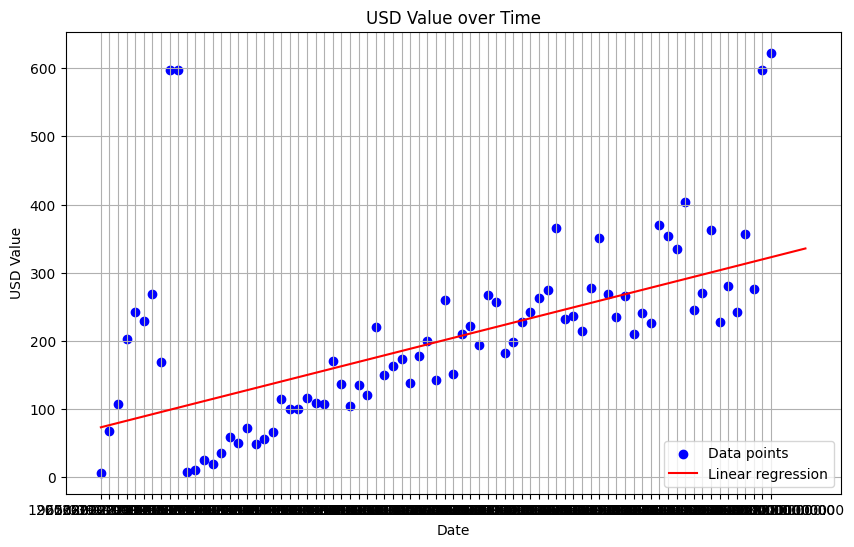

In [28]:
from datetime import datetime, timedelta

plt.figure(figsize=(10, 6))
plt.scatter(df_0011.Date, df_0011['USD Value'], color='blue', label='Data points')

X = df_0011.index.values.reshape(-1, 1)
y = df_0011['USD Value']

model = LinearRegression().fit(X, y)

plt.plot(X, model.predict(X), color='red', label='Linear regression')
plt.title('USD Value over Time')
plt.xlabel('Date')
plt.ylabel('USD Value')
plt.legend()
plt.grid(True)
plt.show()

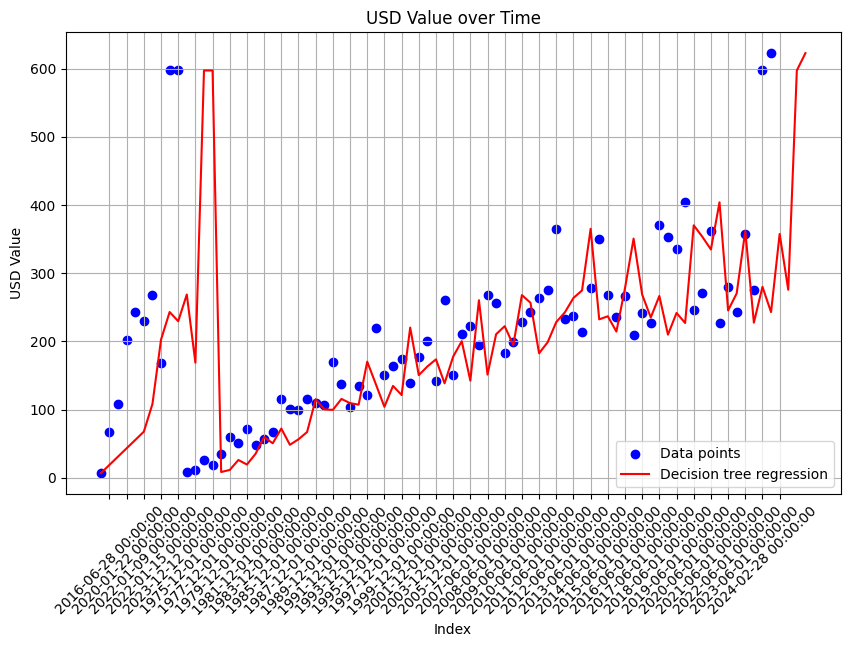

In [13]:
from sklearn.tree import DecisionTreeRegressor

plt.figure(figsize=(10, 6))
plt.scatter(df_0011.Date, df_0011['USD Value'], color='blue', label='Data points')
X = df_0011.index.values.reshape(-1, 1)
y = df_0011['USD Value'].values

model = DecisionTreeRegressor().fit(X, y)
plt.plot(X, model.predict(X), color='red', label='Decision tree regression')
plt.title('USD Value over Time')
plt.xlabel('Index')
plt.ylabel('USD Value')

plt.xticks([i for i in range(1, len(df_0011) + 1, 2)], rotation=45)

plt.legend()
plt.grid(True)
plt.show()

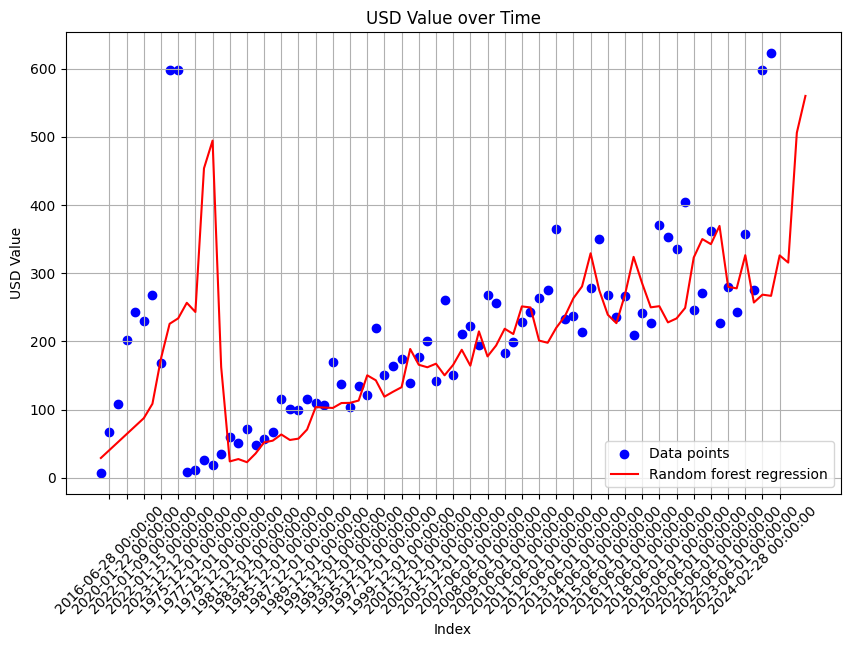

In [14]:
from sklearn.ensemble import RandomForestRegressor

plt.figure(figsize=(10, 6))
plt.scatter(df_0011.Date, df_0011['USD Value'], color='blue', label='Data points')

# Random Forest Regression
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X, y)
plt.plot(X, model.predict(X), color='red', label='Random forest regression')

plt.title('USD Value over Time')
plt.xlabel('Index')
plt.ylabel('USD Value')

plt.xticks([i for i in range(1, len(df_0011) + 1, 2)], rotation=45)

plt.legend()
plt.grid(True)
plt.show()

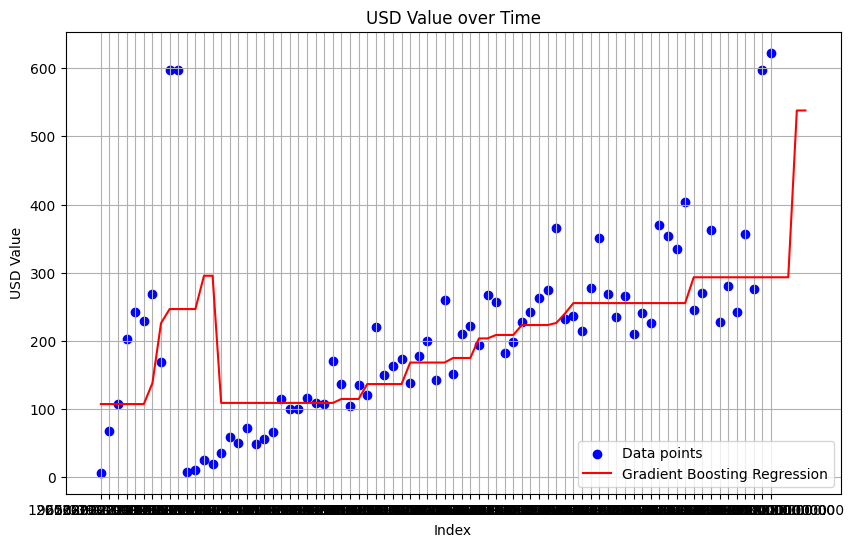

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

plt.figure(figsize=(10, 6))
plt.scatter(df_0011.Date, df_0011['USD Value'], color='blue', label='Data points')

# Gradient Boosting Regression
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='squared_error')
X = df_0011.index.values.reshape(-1, 1)
Y = df_0011['USD Value'].values
model.fit(X, Y)
plt.plot(X, model.predict(X), color='red', label='Gradient Boosting Regression')
plt.title('USD Value over Time')
plt.xlabel('Index')
plt.ylabel('USD Value')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
df_0011_history = pd.read_csv("data/001-1_new.csv")

In [31]:
df_0011_history

,Date,Value 1,Value 2,Value 3,Value 4,Description
0,2009-01-01 00:00:00,427.15,443.23,491.46,523.61,523.61
1,2009-02-01 00:00:00,410.14,432.93,501.28,546.85,546.85
2,2009-03-01 00:00:00,403.73,418.92,464.50,494.89,494.89
3,2009-04-01 00:00:00,411.62,434.49,503.09,548.83,548.83
4,2009-05-01 00:00:00,430.30,446.49,495.07,527.46,527.46
...,...,...,...,...,...,...
177,2023-10-01 00:00:00,443.45,468.09,542.00,591.27,591.27
178,2023-11-01 00:00:00,504.06,523.03,579.93,617.87,617.87
179,2023-12-01 00:00:00,537.52,567.38,656.96,716.69,716.69
180,2024-01-01 00:00:00,542.88,563.31,624.60,665.46,665.46


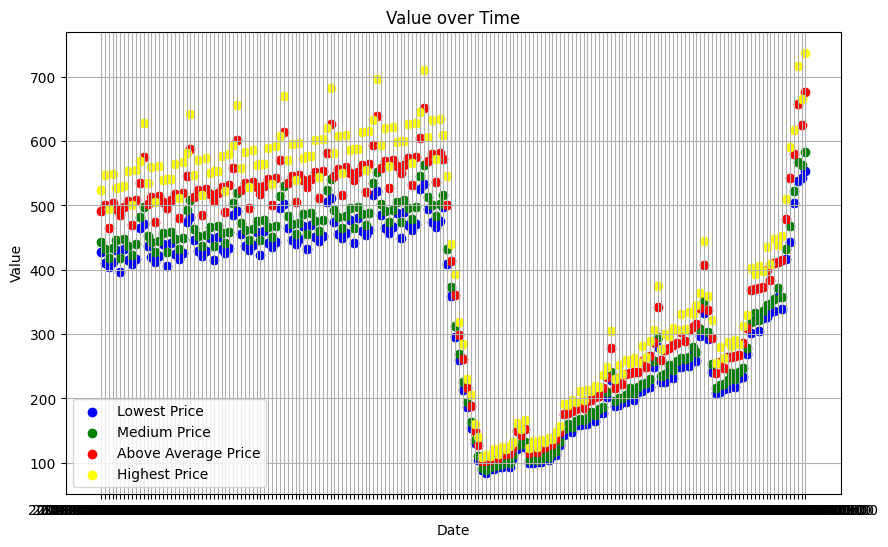

In [32]:
# plot the data
plt.figure(figsize=(10, 6))
plt.scatter(df_0011_history.Date, df_0011_history['Value 1'], color='blue', label='Lowest Price')
plt.scatter(df_0011_history.Date, df_0011_history['Value 2'], color='green', label='Medium Price')
plt.scatter(df_0011_history.Date, df_0011_history['Value 3'], color='red', label='Above Average Price')
plt.scatter(df_0011_history.Date, df_0011_history['Value 4'], color='yellow', label='Highest Price')

plt.title('Value over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


